In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(0)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from scipy.ndimage import label
import time
import torch
import tqdm
from PIL import Image
import pprint
from segmentation import Segmenter, visualized_masks, get_masked_area

In [14]:
num_test_images = 1
visualize = True

# img_dir = '/home/dchenbs/workspace/datasets/coco2017/images/val2017'
# img_dir = '/home/dchenbs/workspace/datasets/CLEVR_v1.0/images/train'
img_dir = '/home/dchenbs/workspace/datasets/v3det/images/a00000066'
image_paths = []
for i in range(num_test_images):
    img_path = os.path.join(img_dir, random.choice(os.listdir(img_dir)))
    image_paths.append(img_path)

In [15]:
import json, requests
import pickle
import base64

def get_segment_from_provider(img_path, url, post_processing=True):

    content_lst = {
        'post_processing': post_processing, 
        'img_path': img_path
    }
    d = {"content_lst": content_lst}#, 'typ': 'None'}
    d = json.dumps(d).encode('utf8')
    r = requests.post(url, data=d)
    js = json.loads(r.text)

    masks_bytes = base64.b64decode(js['result']['response'])
    masks = pickle.loads(masks_bytes)

    return masks

port = '5000'
url = f'http://0.0.0.0:{port}/segment_provider'
masks = get_segment_from_provider(image_paths[0], url)

Running [MOBILE_SAM_V2]: l2.pt
checkpoint_load_scucess


  0%|          | 0/1 [00:00<?, ?it/s]
0: 704x1024 210 objects, 28.5ms
Speed: 4.9ms preprocess, 28.5ms inference, 22.8ms postprocess per image at shape (1, 3, 1024, 1024)


Segmented into 232 masks


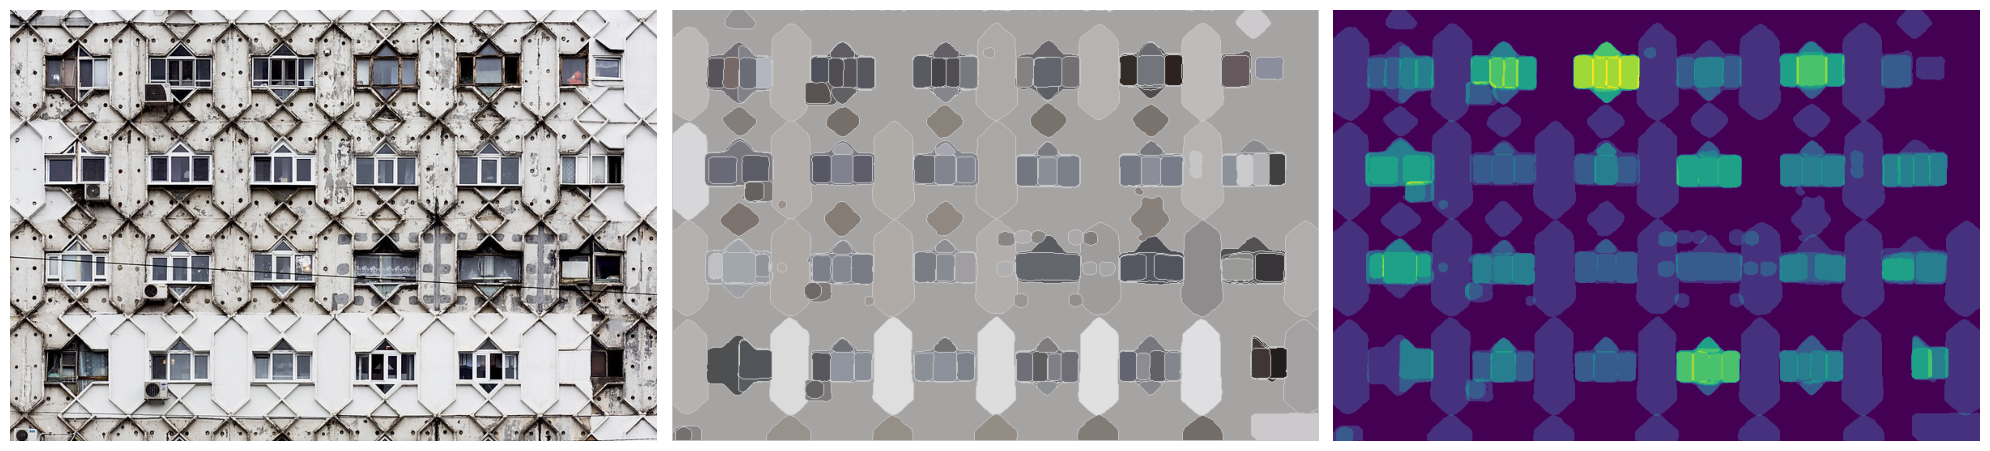

100%|██████████| 1/1 [00:03<00:00,  3.20s/it]

[{'checkpoint': '/home/dchenbs/workspace/cache/sam_weights/mobile_sam_v2/l2.pt',
  'model_name': 'mobile_sam_v2',
  'seconds_per_image': 3.2071187496185303}]


In [12]:
models = [
    
    # ('sam', '/home/dchenbs/workspace/cache/sam_weights/sam/sam_vit_h_4b8939.pth'), 
    #     # 6.972 GB, 1.83 s/image

    # ('sam', '/home/dchenbs/workspace/cache/sam_weights/sam/sam_vit_l_0b3195.pth'), 
    #     # 5.516 GB, 1.59 s/image

    # ('sam', '/home/dchenbs/workspace/cache/sam_weights/sam/sam_vit_b_01ec64.pth'), 
    #     # 4.572 GB, 1.12 s/image
    
    # ('mobile_sam', '/home/dchenbs/workspace/cache/sam_weights/mobile_sam.pt'),
    #     # 4.376 GB, 1.24 s/image
    
    ('mobile_sam_v2', '/home/dchenbs/workspace/cache/sam_weights/mobile_sam_v2/l2.pt'),
    #     # 11.982 GB, 0.20 s/image
    
    # ('repvit_sam', '/home/dchenbs/workspace/Seq2Seq-AutoEncoder/RepViT/sam/weights/repvit_sam.pt'), 
    #     # 4.722 GB, 1.35 s/image
       
    # --- somehow broken

    # ('fast_sam', '/home/dchenbs/workspace/cache/sam_weights/fast_sam/FastSAM-s.pt'),  
    #     # 1.326 GB, 0.34 s/image

    # ('fast_sam', '/home/dchenbs/workspace/cache/sam_weights/fast_sam/FastSAM.pt'), 
    #     # 1.946 GB, 0.24 s/image
]

kwargs = {
    # SAM, FastSAM, MobileSAM, RepViT-SAM
    "points_per_side": 32,
    "points_per_batch": 64,
    "pred_iou_thresh": 0.88,
    "stability_score_thresh": 0.95,
    "stability_score_offset": 1.0,
    "box_nms_thresh": 0.7,
    "crop_n_layers": 0,
    "crop_nms_thresh": 0.7,
    "crop_overlap_ratio": 512 / 1500,
    "crop_n_points_downscale_factor": 1,
    "min_mask_region_area": 0,

    # MobileSAMv2
    "num_box_prompts": 320,
    "object_conf": 0.1,
    "object_iou": 0.9,

}


results = []
for model_name, checkpoint in models:
    print(f'Running [{model_name.upper()}]: {checkpoint.split("/")[-1]}')

    segmenter = None
    torch.cuda.empty_cache()
    segmenter = Segmenter(model_name, checkpoint, **kwargs)
    
    start = time.time()
    for img_path in tqdm.tqdm(image_paths):
        image = np.array(Image.open(img_path).convert('RGB'))
        masks = segmenter(img_path, post_processing=True)
        print(f'Segmented into {len(masks)} masks')
        
        if visualize:
            plt.figure(figsize=(20, 8))
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.axis('off')

            canvas = visualized_masks(masks, image)
            plt.subplot(1, 3, 2)
            plt.imshow(canvas)
            plt.axis('off')

            masked_area, non_masked_area = get_masked_area(masks)
            plt.subplot(1, 3, 3)
            plt.imshow(masked_area*int(255/max(masked_area.flatten())))
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    result = {
        'model_name': model_name,
        'checkpoint': checkpoint,
        'seconds_per_image': (time.time()-start)/num_test_images,
    }
    results.append(result)

pprint.pprint(results)